In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential

import os
from glob import glob
import datetime 
import copy

In [2]:
%matplotlib inline
%load_ext tensorboard

In [3]:
np.random.seed(128)
tf.random.set_seed(128)

In [4]:
CUDA = tf.test.is_built_with_cuda()
DEVICE = tf.device(tf.test.gpu_device_name())

In [5]:
df = pd.read_csv('../data/HAM10000_balanced.csv')
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target
0,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,-1,Non-Melanoma
1,11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,Benign keratosis-like lesions,-1,Non-Melanoma
2,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma
3,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma
4,16,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma


In [6]:
imageid_path = {os.path.splitext(os.path.basename(x))[0]: x 
                for x in glob(os.path.join('..\\data', '*', '*.jpg'))}

In [7]:
df['path'] = df['image_id'].map(imageid_path.get)

In [8]:
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target,path
0,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029176.jpg
1,11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029396.jpg
2,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
3,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
4,16,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0025915.jpg


In [9]:
df['binary_target'].value_counts()

-1    1113
 0    1113
Name: binary_target, dtype: int64

In [10]:
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target,path
0,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029176.jpg
1,11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029396.jpg
2,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
3,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
4,16,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0025915.jpg


C:\Users\tomoto\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


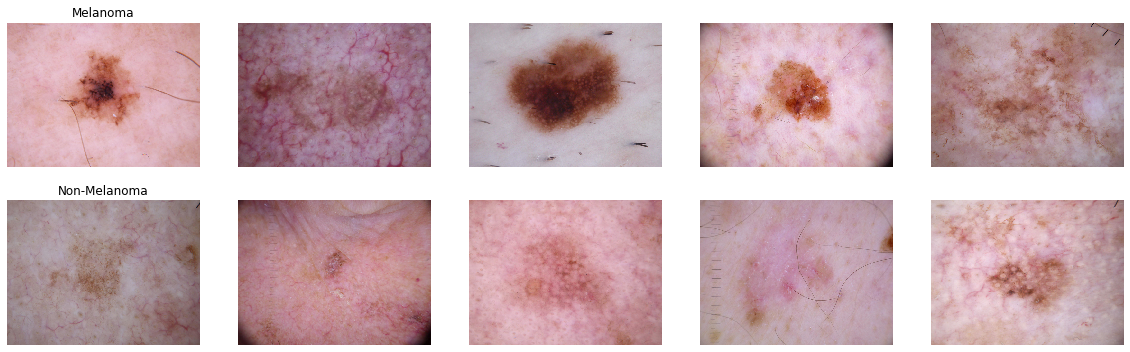

In [11]:
n_samples = 5
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cat_target']).groupby('cat_target')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=128).iterrows()):
        img = mpimg.imread(c_row['path'])
        c_ax.imshow(img)
        c_ax.axis('off')
fig.savefig('./output/category_samples.png', dpi=100)
fig.show()

In [12]:
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target,path
0,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029176.jpg
1,11,HAM_0004234,ISIC_0029396,bkl,histo,85.0,female,chest,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0029396.jpg
2,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
3,15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031326.jpg
4,16,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0025915.jpg


In [13]:
raw_train_df, valid_df = train_test_split(df, 
                 test_size = 0.2, 
                  # hack to make stratification work                  
                 stratify = df['binary_target'])
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

1780 training masks
446 validation masks


In [14]:
raw_train_df

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,binary_target,cat_target,path
193,1029,HAM_0006243,ISIC_0031436,bkl,consensus,75.0,male,upper extremity,Benign keratosis-like lesions,-1,Non-Melanoma,..\data\HAM10000\ISIC_0031436.jpg
918,1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0032982.jpg
1792,2974,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,Basal cell carcinoma,-1,Non-Melanoma,..\data\HAM10000\ISIC_0028978.jpg
912,1794,HAM_0003700,ISIC_0033616,mel,histo,40.0,female,lower extremity,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0033616.jpg
1221,2103,HAM_0004354,ISIC_0026877,mel,histo,70.0,male,abdomen,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0026877.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
1206,2088,HAM_0000320,ISIC_0027863,mel,histo,55.0,male,back,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0027863.jpg
1842,4201,HAM_0000514,ISIC_0028934,nv,follow_up,80.0,male,trunk,Melanocytic nevi,-1,Non-Melanoma,..\data\HAM10000\ISIC_0028934.jpg
1122,2004,HAM_0002534,ISIC_0027620,mel,histo,80.0,male,lower extremity,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0027620.jpg
637,1519,HAM_0006330,ISIC_0033274,mel,histo,80.0,female,face,Melanoma,0,Melanoma,..\data\HAM10000\ISIC_0033274.jpg


In [15]:
GAUSSIAN_NOISE = 0.05
# number of validation images to use
VALID_IMG_COUNT = 446
BASE_MODEL='MobileNet' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 256
SAMPLE_PER_GROUP = 2200
LEARN_RATE = 2e-4
EPOCHS = 25
FLATTEN = True
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [16]:
datagen_args = {
    "horizontal_flip": True,
    "vertical_flip": True
}
valid_args = {}
core_idg = ImageDataGenerator(**datagen_args)
valid_idg = ImageDataGenerator(**valid_args)

In [17]:
def flow_from_dataframe(img_data_gen, df, path_col, target_col, **dflow_args):
    in_df = df.copy()
    in_df[path_col] = in_df[path_col].map(str)
    in_df[target_col] = in_df[target_col].map(lambda x: np.array(x))
    df_gen = img_data_gen.flow_from_dataframe(in_df,
                                             x_col=path_col,
                                             y_col=target_col,
                                             class_mode='raw',
                                             **dflow_args)
    df_gen._targets = np.stack(df_gen.labels, 0)
    return df_gen

In [18]:
train_gen = flow_from_dataframe(core_idg, raw_train_df, 
                             path_col = 'path',
                            target_col = 'binary_target', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            target_col = 'binary_target', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

Found 1780 validated image filenames.
Found 446 validated image filenames.
(446, 224, 224, 3) (446,)


In [19]:
base_model = keras.applications.DenseNet121(input_shape=(224,224,3),
                                           include_top=False)

29089792/29084464 [==============================] - 6s 0us/step


In [23]:
feature_batch = base_model(train_gen)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [ ]:
print(feature_batch)